##### Imports

In [1]:
import itertools
from tqdm.auto import tqdm, trange
import random
import os
import sys
from io import StringIO
from IPython import get_ipython


import torch
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset, load_from_disk

from pyvene import(
    CausalModel, IntervenableModel, IntervenableConfig,
    RepresentationConfig, RotatedSpaceIntervention,
    BoundlessRotatedSpaceIntervention,
)

from transformers import (
    AutoTokenizer, get_scheduler,
    AutoModelForCausalLM, GPT2LMHeadModel
)

from accelerate import Accelerator
from accelerate.utils import set_seed

import transformers
transformers.logging.set_verbosity_error()

In [2]:
"""
# ipython_exit.py
Allows exit() to work if script is invoked with IPython without
raising NameError Exception. Keeps kernel alive.

Use: import variable 'exit' in target script with
     'from ipython_exit import exit'    
"""

class IpyExit(SystemExit):
    """Exit Exception for IPython.

    Exception temporarily redirects stderr to buffer.
    """
    def __init__(self):
        # print("exiting")  # optionally print some message to stdout, too
        # ... or do other stuff before exit
        sys.stderr = StringIO()

    def __del__(self):
        sys.stderr.close()
        sys.stderr = sys.__stderr__  # restore from backup


def ipy_exit():
    raise IpyExit


if get_ipython():    # ...run with IPython
    exit = ipy_exit  # rebind to custom exit
else:
    exit = exit      # just make exit importable

##### Constants

In [10]:
seed = 42
mixed_precision = 'no'  # choose from no, fp16, bf16 or fp8
# needed for dataset generation in case of counterfactual dataset
batch_size = 8

# Longest command is 9 words : https://arxiv.org/pdf/1711.00350
MAX_COMMAND_LEN = 9
placeholder = '<empty>'

set_seed(seed)

##### utility functions

In [4]:
def rem_dups(l):
    l_un = []
    for item in l:
        if l not in l_un:
            l_un.append(item)
    return l_un

# https://stackoverflow.com/questions/10823877/what-is-the-fastest-way-to-flatten-arbitrarily-nested-lists-in-python
def flatten(container):
    for i in container:
        if isinstance(i, (list, tuple)):
            for j in flatten(i):
                yield j
        else:
            yield i

def add_empty_token(x):
    command_str = x['commands']
    command = command_str.split()
    padded_command = []
    index = 0
    c = 0
    while index < MAX_COMMAND_LEN:
        expected_cs = command_structure[index]
        if c < len(command) and command[c] in expected_cs:
            padded_command.append(command[c])
            c += 1
        else:
            padded_command.append(placeholder)
        index += 1

    x[input_column] = ' '.join(padded_command)
    return x

##### Causal model

In [5]:
verbs = {
    'jump': 'I_JUMP',
    'look': 'I_LOOK',
    'walk': 'I_WALK',
    'run': 'I_RUN'
}
directions = {
    'left': 'I_TURN_LEFT',
    'right': 'I_TURN_RIGHT',
}
around_opposite = {
    'around': ['direction', 'action']*4,
    'opposite': ['direction', 'direction', 'action'],
}
nums = {
    'twice': 2,
    'thrice': 3,
}
conjs = ['and', 'after']

# command structure
command_structure = {
    0: verbs,
    1: around_opposite,
    2: directions,
    3: nums,
    4: conjs,
    5: verbs,  # 0
    6: around_opposite,  # 1
    7: directions,  # 2
    8: nums,  # 3
}


### VARIABLES ###

leaves = [
    "verb1", "ar_op1", "dir1", "num1",
    "conj",
    "verb2", "ar_op2", "dir2", "num2"
]
non_leaves = ["verb_res", "dir_res", "ar_op_res", "num_res", "conj_res"]
variables = leaves + non_leaves


### FUNCTIONS ###

def verb_resolution(verb1, verb2):
    verb1 = verbs[verb1] if verb1 in verbs else verb1
    verb2 = verbs[verb2] if verb2 in verbs else verb2
    return [verb1, verb2]

def direction_resolution(dir1, dir2):
    dir1 = directions[dir1] if dir1 in directions else dir1
    dir2 = directions[dir2] if dir2 in directions else dir2
    return [dir1, dir2]

def around_opposite_resolution(verb_res, ar_op1, ar_op2, dir_res):
    # reformat
    items = [[verb_res[0], ar_op1, dir_res[0]], [verb_res[1], ar_op2, dir_res[1]]]
    res_items = []
    for item in items:
        # get verb, ar_op, direction
        verb = item[0]
        direction = item[2]
        ar_op = item[1]
        # resolve
        if ar_op == placeholder:
            res_items.append([direction, verb])
        else:
            res_item = around_opposite[ar_op]
            res_items.append([direction if i == 'direction' else verb for i in res_item])
    return res_items

def num_resolution(ar_op_res, num1, num2):
    res_items = []
    # resolve num1
    if num1 != placeholder:
        res_items.append(ar_op_res[0]*nums[num1])
    else:
        res_items.append(ar_op_res[0])
    # resolve num2
    if num2 != placeholder:
        res_items.append(ar_op_res[1]*nums[num2])
    else:
        res_items.append(ar_op_res[1])
    return res_items

def conj_resolution(num_res, conj):
    if conj == 'and':
        output =  num_res[0] + num_res[1]
    elif conj == 'after':
        output = num_res[1] + num_res[0]
    else:
        output = num_res[0]
    # flatten?
    output = [l for l in output if l != placeholder]
    return ' '.join(output)


functions = {

    # leaves
    "verb1": lambda x: x, 
    "ar_op1": lambda x: x,
    "dir1": lambda x: x,
    "num1": lambda x: x,
    "conj": lambda x: x,
    "verb2": lambda x: x,
    "ar_op2": lambda x: x,
    "dir2": lambda x: x,
    "num2": lambda x: x,

    # resolve verbs
    "verb_res": verb_resolution,

    # resolve directions
    "dir_res": direction_resolution,

    # resolve around/opposite
    "ar_op_res": around_opposite_resolution,

    # resolve num
    "num_res": num_resolution,

    # resolve conjugation
    "conj_res": conj_resolution,
}


### VALUES (output) ###

values = dict()

# leaves all values
values["verb1"] = list(verbs.keys())
values["verb2"] = list(verbs.keys())
values["ar_op1"] = list(around_opposite.keys())
values["ar_op2"] = list(around_opposite.keys())
values["dir1"] = list(directions.keys())
values["dir2"] = list(directions.keys())
values["num1"] = list(nums.keys())
values["num2"] = list(nums.keys())
values["conj"] = conjs

# verb_res all values
all_verbs = list(itertools.product(values["verb1"], values["verb2"]))
values["verb_res"] = rem_dups([verb_resolution(tup[0], tup[1]) for tup in all_verbs])

# direction resolution all values
all_dirs = list(itertools.product(values["dir1"], values["dir2"]))
values["dir_res"] = rem_dups([direction_resolution(tup[0], tup[1]) for tup in all_dirs])

# around/opposite resolution all values
all_ar_op = list(itertools.product(values["verb_res"], values["ar_op1"], values["ar_op2"], values["dir_res"]))
values["ar_op_res"] = rem_dups([around_opposite_resolution(tup[0], tup[1], tup[2], tup[3]) for tup in all_ar_op])

# num resolution all values
all_nums = list(itertools.product(values["ar_op_res"], values["num1"], values["num2"]))
values["num_res"] = rem_dups([num_resolution(tup[0], tup[1], tup[2]) for tup in all_nums])

# conj resolution all values
all_conj = list(itertools.product(values["num_res"], values["conj"]))
values["conj_res"] = list(set([conj_resolution(tup[0], tup[1]) for tup in all_conj]))


### PARENTS ###

parents = {v:[] for v in variables}

parents["verb_res"] = ["verb1", "verb2"]
parents["dir_res"] = ["dir1", "dir2"]
parents["ar_op_res"] = ["verb_res", "ar_op1", "ar_op2", "dir_res"]
parents["num_res"] = ["ar_op_res", "num1", "num2"]
parents["conj_res"] = ["num_res", "conj"]


### POSITIONS ###

# a dictionary with nodes as keys and positions as values
pos = {
    "verb1": (0.5, 0),
    "ar_op1": (1, 0),
    "dir1": (1.5, 0),
    "num1": (2, 0),
    "conj": (2.5, 0),
    "verb2": (3, 0),
    "ar_op2": (3.5, 0),
    "dir2": (4, 0),
    "num2": (4.5, 0),
    "verb_res": (1, 1),
    "dir_res": (3, 1),
    "ar_op_res": (2, 2),
    "num_res": (2.5, 3),
    "conj_res": (3, 4),
}

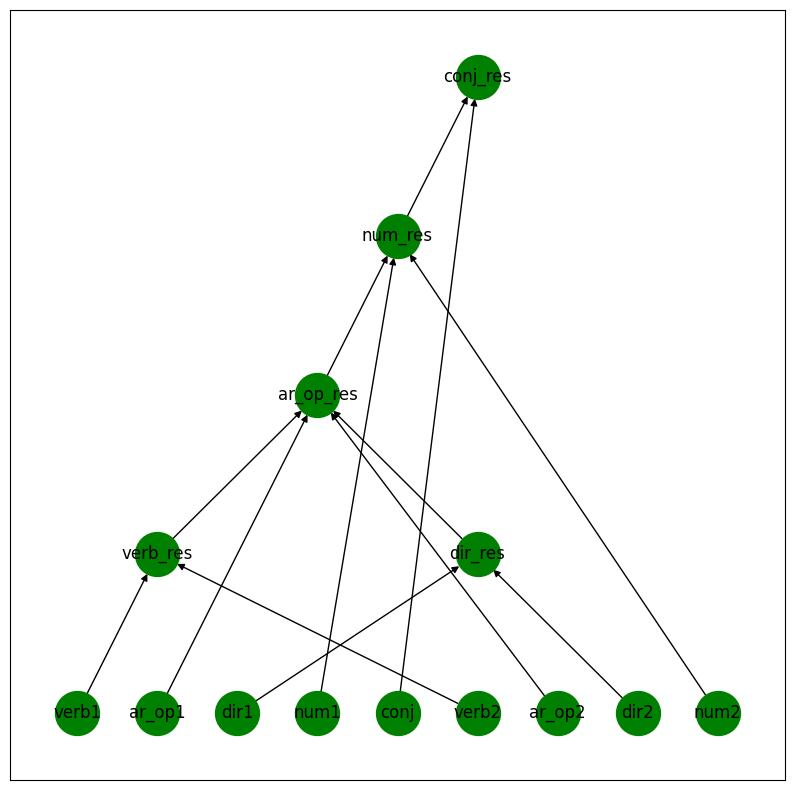

In [6]:
causal_model = CausalModel(variables, values, parents, functions, pos=pos)
causal_model.print_structure()

##### Load dataset

In [7]:
# dataset splits
scan_simple = load_dataset('scan', 'simple', trust_remote_code=True)

# train and test splits
simple_train = scan_simple['train']
simple_test = scan_simple['test']
data_splits = [simple_train, simple_test]

# cols
column_names = simple_train.column_names
input_column = column_names[0]
output_column = column_names[1]

# filter out turns
simple_train = simple_train.filter(lambda x: 'turn' not in x["commands"].split())
simple_test = simple_test.filter(lambda x: 'turn' not in x["commands"].split())

simple_train_padded = simple_train.map(
    add_empty_token,
    batched=False,
    desc="Running tokenizer on dataset",
)
simple_test_padded = simple_test.map(
    add_empty_token,
    batched=False,
    desc="Running tokenizer on dataset",
)

Filter:   0%|          | 0/16728 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/11362 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/2834 [00:00<?, ? examples/s]

##### Intervention examples

##### Causal model with no intervention

base : {'commands': 'walk <empty> <empty> <empty> after run around right twice', 'actions': 'I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_WALK'}
No intervention:
 defaultdict(None, {'ar_op1': '<empty>', 'ar_op2': 'around', 'conj': 'after', 'dir1': '<empty>', 'dir2': 'right', 'num1': '<empty>', 'num2': 'twice', 'verb1': 'walk', 'verb2': 'run', 'dir_res': ['<empty>', 'I_TURN_RIGHT'], 'verb_res': ['I_WALK', 'I_RUN'], 'ar_op_res': [['<empty>', 'I_WALK'], ['I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN']], 'num_res': [['<empty>', 'I_WALK'], ['I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN']], 'conj_res': 'I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN

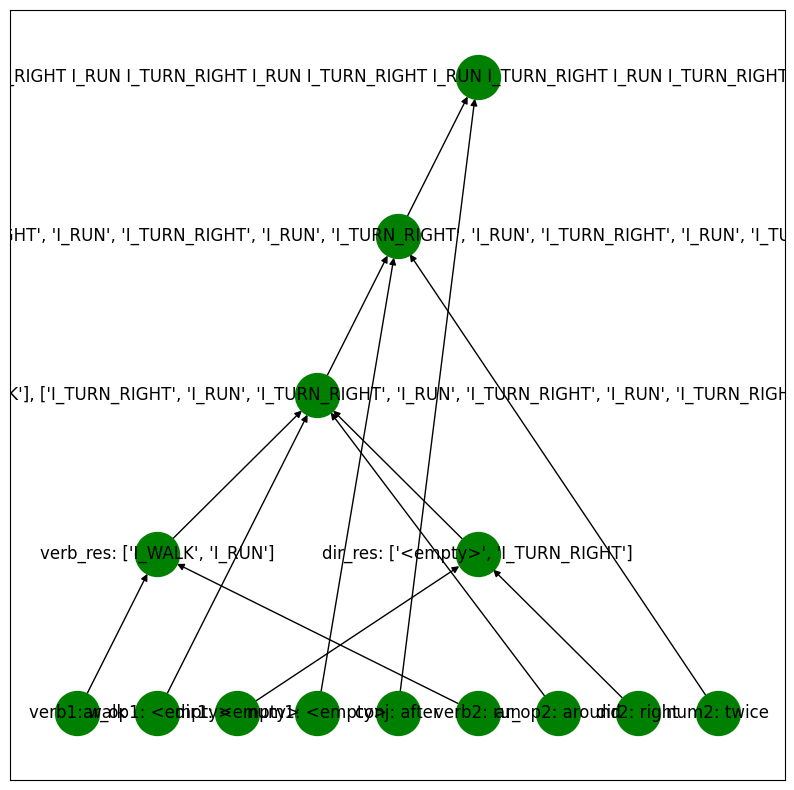

In [11]:
example = simple_train_padded[1]
print('base : {}'.format(example))

padded_command = example[input_column].split()
# assume leaves are correctly ordered from left to right
causal_model_inputs = {leaves[i]:padded_command[i] for i in range(MAX_COMMAND_LEN)}
base_setting = causal_model.run_forward(causal_model_inputs)
print("No intervention:\n", base_setting, "\n")
causal_model.print_setting(base_setting)

##### Causal model with an intervention

Intervention setting trn2_dir2 to left turn:



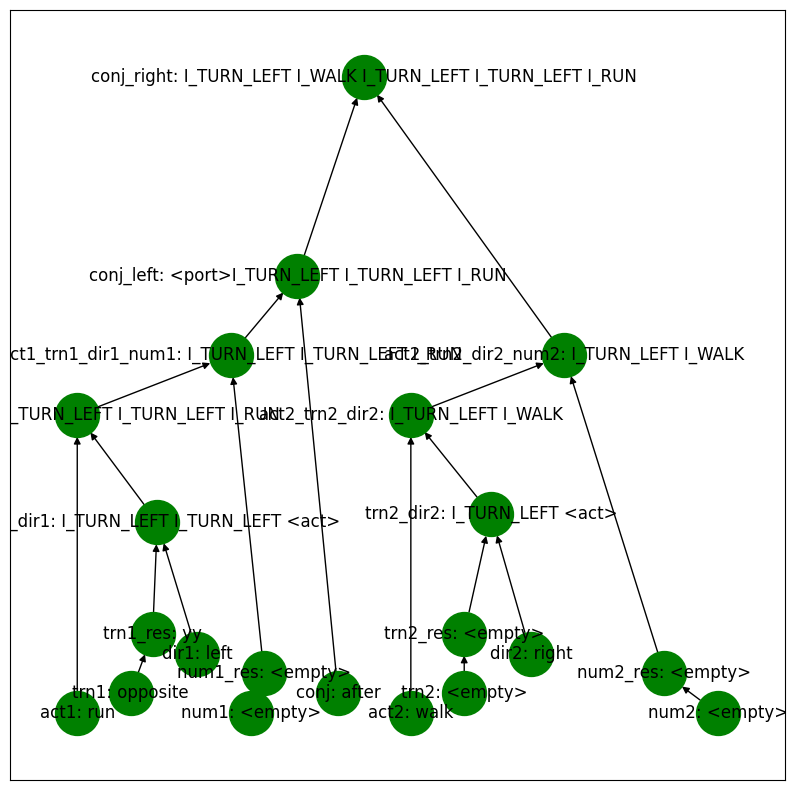

In [84]:
# TODO:

print("Intervention setting trn2_dir2 to left turn:\n",)
## how to do this intervention for gpt? ##
causal_model_inputs['trn2_dir2'] = directions['left'] + ' '+ACT

causal_model.print_setting(causal_model.run_forward(causal_model_inputs))

#### Interchange intervention

base example : {'commands': 'run opposite left <empty> after walk <empty> right <empty>', 'actions': 'I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN'}
source example : {'commands': 'walk <empty> <empty> <empty> after run around right twice', 'actions': 'I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_WALK'}


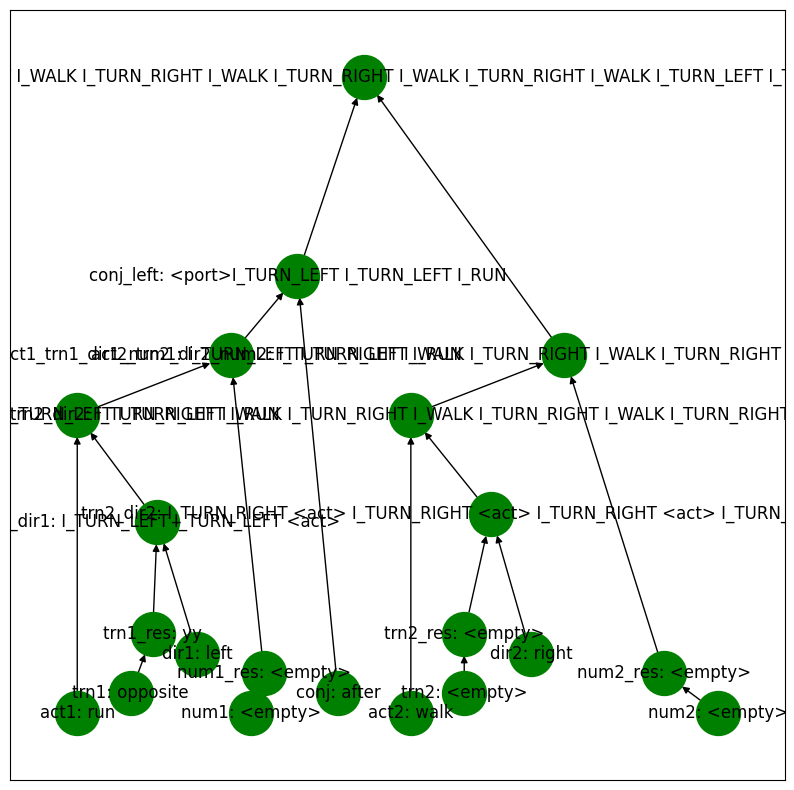

In [85]:
example = simple_train_padded[1]
print('base example : {}'.format(example))
padded_command = example[input_column].split()
base = {leaves[i]:padded_command[i] for i in range(max_command_len)}

source_example = simple_train_padded[2]
print('source example : {}'.format(source_example))
padded_command = source_example[input_column].split()
source = {leaves[i]:padded_command[i] for i in range(max_command_len)}
setting = causal_model.run_interchange(base, {"trn2_dir2": source})
causal_model.print_setting(setting)

In [86]:
print(base_setting['trn2_dir2'])
print(setting['trn2_dir2'])

I_TURN_RIGHT <act>
I_TURN_RIGHT <act> I_TURN_RIGHT <act> I_TURN_RIGHT <act> I_TURN_RIGHT <act>


### Intervention on conj_left

#### Build factual SCAN dataset

Make sure every sample has a conj. Sample each leaf and make sure it's a valid leaf value configuration for the input.

In [87]:
def validate_leaf_config(input):
    # condition1: conj cannot be empty
    if input['conj'] == EMPTY:
        return True
    # condition2 : actions cannot be empty
    if input['act1'] == EMPTY or input['act2'] == EMPTY:
        return True
    # condition3 : if direction is empty, turn has to be empty
    if input['dir1'] == EMPTY and input['trn1'] != EMPTY:
        return True
    if input['dir2'] == EMPTY and input['trn2'] != EMPTY:
        return True


def input_sampler():
    invalid_input = True
    while invalid_input:
        input = {}
        # randomly sample a value at each position
        for posn, val in command_structure.items():
            if isinstance(val, dict):
                command_type_keys = list(val.keys())
            elif isinstance(val, list):
                command_type_keys = val
            else:
                raise ValueError("Invalid command type. Check command type maps")
            r_key = random.choice(command_type_keys)
            # assuming leaves is a list with ordered values
            input[leaves[posn]] = r_key
        # check if sampled example is valid, else sample again
        invalid_input = validate_leaf_config(input)
    return input

#input_sampler()


In [88]:
# len(simple_train_padded) ~ 17k
n_examples = 20000
n_val_examples = 4000
n_test_examples = 4000

# input_ids: {'act1': 'jump', 'trn1': '<empty>', ...}, labels: defaultdict(None, {'act1': 'jump', 'act2': 'jump', ...}
train_examples = causal_model.generate_factual_dataset(
    size=n_examples,
    sampler=input_sampler,
    return_tensors=False
)
val_examples = causal_model.generate_factual_dataset(
    size=n_val_examples,
    sampler=input_sampler,
    return_tensors=False
)
test_examples = causal_model.generate_factual_dataset(
    size=n_test_examples,
    sampler=input_sampler,
    return_tensors=False
)

#### Train GPT2 on generated dataset (all samples with conj)

Hyperparameters and setup

In [89]:
gradient_accumulation_steps = 1
lr = 5e-5
train_steps = 100000
eval_steps = 5000
warmup_steps = 0
num_workers = os.cpu_count()
max_source_length = 512
weight_decay = 0.0
lr_scheduler_type = 'linear'

model_name_or_path = 'openai-community/gpt2'
output_dir = '/home/drdo/Caricatures/models/scan_simple_gen_gpt2'

# initialize accelerator
accelerator = Accelerator(
    mixed_precision=mixed_precision,
    gradient_accumulation_steps=gradient_accumulation_steps,
    log_with="tensorboard",
    project_dir=output_dir
)
# we need to initialize the trackers we use, and also store our configuration
track_config = {
    "lr": lr,
    "train_steps": train_steps,
    "seed": seed,
    "train_batch_size": batch_size,
}
accelerator.init_trackers('runs', track_config)

# tokenizer special tokens
special_tokens_dict = {
    "pad_token": "<pad>",
    "sep_token": "<sep>",
}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Load model and tokenizer

In [90]:
# tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path,)
tokenizer.add_special_tokens(special_tokens_dict)

# model
model = AutoModelForCausalLM.from_pretrained(model_name_or_path,)
# resize the embeddings when necessary to avoid index errors
embedding_size = model.get_input_embeddings().weight.shape[0]
if len(tokenizer) > embedding_size:
    model.resize_token_embeddings(len(tokenizer))

/home/drdo/anaconda3/envs/nlp/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Process generated dataset

In [91]:
# convert examples to Huggingface dataset
train_dataset = Dataset.from_list(train_examples)
val_dataset = Dataset.from_list(val_examples)

# process dataset for gpt input
def process_dataset(x):

    command_list = []
    leaf2comm = x['input_ids']
    # make sure leaves are odered correctly
    for leaf in leaves:
        command_list.append(leaf2comm[leaf])
    command = ' '.join(command_list)

    # only taking final output value
    action = x['labels']['conj_right']
    x['commands'] = command
    x['actions'] = action

    return x


with accelerator.main_process_first():
    train_dataset = train_dataset.map(
        process_dataset,
        batched=False,
        num_proc=1,
        remove_columns=train_dataset.column_names,
    )
    val_dataset = val_dataset.map(
        process_dataset,
        batched=False,
        num_proc=1,
        remove_columns=val_dataset.column_names,
    )

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [92]:
column_names = train_dataset.column_names
input_column = column_names[0]
output_column = column_names[1]

# preprocess dataset
def preprocess_function(examples):
    # commands, actions
    inputs = examples[input_column]
    targets = examples[output_column]

    # tokenize as single sequence separated by special token
    model_inputs = tokenizer(
        [i+tokenizer.sep_token for i in inputs],
        [t+tokenizer.eos_token for t in targets],
        padding='max_length', max_length=max_source_length
    )
    # labels same as inputs. labels shifted right in the model forward by default
    model_inputs['labels'] = model_inputs['input_ids'].copy()
    # set label padding to -100 
    model_inputs['labels'] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in model_inputs['labels']
    ]

    return model_inputs


with accelerator.main_process_first():
    train_dataset = train_dataset.map(
        preprocess_function,
        batched=True,
        num_proc=num_workers,
        remove_columns=column_names,
    )
    val_dataset = val_dataset.map(
        preprocess_function,
        batched=True,
        num_proc=num_workers,
        remove_columns=column_names,
    )

#print(tokenizer.decode(train_dataset[0]['input_ids'], skip_special_tokens=False))

Map (num_proc=32):   0%|          | 0/20000 [00:00<?, ? examples/s]

Map (num_proc=32):   0%|          | 0/4000 [00:00<?, ? examples/s]

Dataloaders, optimizer, scheduler

In [93]:
from transformers import default_data_collator

# data collator and loaders
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size
)
val_dataloader = DataLoader(
    val_dataset, collate_fn=default_data_collator, batch_size=batch_size
)

# prepare optimizer and schedule (linear warmup and decay)
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": weight_decay,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=lr)

# scheduler
lr_scheduler = get_scheduler(
    name=lr_scheduler_type,
    optimizer=optimizer,
    num_warmup_steps=warmup_steps * accelerator.num_processes,
    num_training_steps=train_steps * accelerator.num_processes,
)

Train

In [94]:
# prepare everything for accelerator
model, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader, lr_scheduler
)

global_step = 0  # tracks total steps
total_loss = 0  # total loss before each eval

accelerator.log({
    "train_batch_size": batch_size,
    "eval_batch_size": batch_size,
    "gpus": accelerator.state.num_processes
},
    step=global_step + 1,
)

In [95]:
# main progress bar
progress_bar = tqdm(range(global_step, train_steps), disable=not accelerator.is_main_process, position=0)
# val bar
val_bar = tqdm(range(len(val_dataloader)), position=1)

while True:

    model.train()

    for batch in train_dataloader:
        with accelerator.accumulate(model):
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.detach().float()
            accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        # checks if the accelerator has performed an optimization step behind the scenes
        if accelerator.sync_gradients:
            progress_bar.update(1)

        if (global_step + 1) % eval_steps == 0:
            model.eval()
            val_loss = 0
            
            for batch in val_dataloader:
                with torch.no_grad():
                    outputs = model(**batch)
                    val_loss += outputs.loss.item()

                val_bar.update(1)

            val_bar.refresh()
            val_bar.reset()

            accelerator.print('step : {}, val loss  : {}'.format(global_step + 1, val_loss/len(val_dataloader)))
            accelerator.log({
                "train_loss": total_loss / (eval_steps * accelerator.state.num_processes * batch_size),
                "val_loss": val_loss / len(val_dataloader)
            },
                step=global_step + 1,
            )

            # save the model, optimizer, lr_scheduler, and seed states by calling `save_state`
            # saved to folders named `checkpoint-{global_step}`
            # will contain files: "pytorch_model.bin", "optimizer.bin", "scheduler.bin", and "random_states.pkl"
            # if mixed precision was used, will also save a "scalar.bin" file
            c_dir = f"checkpoint-{global_step + 1}"
            if output_dir is not None:
                output_c_dir = os.path.join(output_dir, c_dir)
                accelerator.save_state(output_c_dir)
                # save config
                accelerator.wait_for_everyone()
                unwrapped_model = accelerator.unwrap_model(model)
                # model.config.save_pretrained(output_dir)
                unwrapped_model.config.save_pretrained(
                    output_c_dir, is_main_process=accelerator.is_main_process, save_function=accelerator.save
                )
                tokenizer.save_pretrained(output_c_dir)

            model.train()
            total_loss = 0

        global_step += 1

        if global_step >= train_steps:
            exit()


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Load trained GPT2 (on original SCAN dataset)

In [52]:
checkpoint = '/home/drdo/Caricatures/models/scan_distilgpt2/checkpoint-40000'
#checkpoint = '/users/ujan/caricatures/models/scan/distilgpt2_40k'
max_gen_length = 512

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = GPT2LMHeadModel.from_pretrained(checkpoint)
model.generation_config.max_length = max_gen_length

In [53]:
#generation_mode = GenerationMode.GREEDY_SEARCH

context = 'run <empty> right twice after walk <empty> right twice'
inputs = tokenizer(context+tokenizer.sep_token, return_tensors="pt")

output = model.generate(**inputs)[0]
output = tokenizer.decode(output, skip_special_tokens=False).replace(context+tokenizer.sep_token, '')
output = output.replace(tokenizer.eos_token, '')
print(output)

I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN


#### Eval on generated test data

In [ ]:
# convert examples to Huggingface dataset
test_dataset = Dataset.from_list(test_examples)
# process dataset for gpt input
def process_dataset(x):

    command_list = []
    leaf2comm = x['input_ids']
    # make sure leaves are odered correctly
    for leaf in leaves:
        command_list.append(leaf2comm[leaf])
    command = ' '.join(command_list)

    # only taking final output value
    action = x['labels']['conj_right']
    x['commands'] = command
    x['actions'] = action

    return x


test_dataset = test_dataset.map(
    process_dataset,
    batched=False,
    num_proc=1,
    remove_columns=test_dataset.column_names,
)


column_names = test_dataset.column_names
input_column = column_names[0]
output_column = column_names[1]

testset = test_dataset  #.select(range(100))

count = 0
model.to("cuda")
bar = tqdm(range(len(testset)))
for example in testset:
    command = example[input_column]
    label = example[output_column]
    inputs = tokenizer(command+tokenizer.sep_token, return_tensors="pt").to("cuda")
    output = model.generate(**inputs)[0].to("cpu")
    output = tokenizer.decode(output, skip_special_tokens=False).replace(command+tokenizer.sep_token, '')
    output = output.replace(tokenizer.eos_token, '')
    if output == label:
        count += 1
    bar.update(1)

print(count/len(testset))

#### Build 'perfect' counterfactual dataset

In [10]:
def validate_leaf_config_counterfactual(input):
    # condition1: conj cannot be empty
    if input['conj'] == EMPTY:
        return True
    # condition2 : actions cannot be empty
    if input['act1'] == EMPTY or input['act2'] == EMPTY:
        return True
    # condition3 : if direction is empty, turn has to be empty
    if input['dir1'] == EMPTY and input['trn1'] != EMPTY:
        return True
    if input['dir2'] == EMPTY and input['trn2'] != EMPTY:
        return True
    

def validate_by_model(x, causal_model, model, tokenizer, device):
    command = ' '.join(list(x.values()))
    label = causal_model.run_forward(x)['conj_right']
    inputs = tokenizer(command+tokenizer.sep_token, return_tensors="pt").to(device)
    output = model.generate(**inputs)[0].to("cpu")
    output = tokenizer.decode(output, skip_special_tokens=False).replace(command+tokenizer.sep_token, '')
    output = output.replace(tokenizer.eos_token, '')
    if output == label:
        return True
    else:
        return False


def generate_counterfactual_dataset_conj_left(
        causal_model,
        model,
        tokenizer, 
        device,
        size,
        intervention_id,
        batch_size,
        sampler=None,
        intervention_sampler=None,
        filter=None,
    ):
        # all non leaf non output variables
        maxlength = len(
            [
                var
                for var in causal_model.variables
                if var not in causal_model.inputs and var not in causal_model.outputs
            ]
        )
        if sampler is None:
            sampler = causal_model.sample_input
        if intervention_sampler is None:
            intervention_sampler = causal_model.sample_intervention

        examples = []
        bar = tqdm(range(size))
        while len(examples) < size:
            # dict with intermediate (non leaf) variable(s) and its (their) (intervened) value(s)
            # Ex: sample_intervention:
            # randomly select intermediate variables to intervene, then randomly select
            # possible values from their range
            intervention = intervention_sampler()
            if filter is None or filter(intervention):
                # same intervention for each batch
                for _ in range(batch_size):
                    example = dict()

                    # sample base input
                    invalid_input = True
                    # check if base is solved by given model
                    model_solvable = False
                    while invalid_input and not model_solvable:
                        base = sampler()
                        invalid_input = validate_leaf_config_counterfactual(base)
                        if not invalid_input:
                            model_solvable = validate_by_model(base, causal_model, model, tokenizer, device)

                    sources = []
                    # intervened_var : source input tensor
                    source_dic = {}
                    for var in causal_model.variables:
                        if var not in intervention:
                            continue
                        # sample input to match sampled intervention value for each intervened variable
                        # to get source input
                        # Ex: sample_input_tree_balanced:
                        # This will generate balanced samples since an output is first chosen at random
                        # and one of the possible input settings is derived recursively, top down.
                        # If output_var and out_var_value is given, this will generate an input setting
                        # to match the output variable.
                        # output_var can be an intermediate variable
                        invalid_input = True
                        # check if source is solved by given model
                        model_solvable = False
                        while invalid_input and not model_solvable:
                            source = sampler(output_var=var, output_var_value=intervention[var])
                            invalid_input = validate_leaf_config_counterfactual(source)
                            if not invalid_input:
                                model_solvable = validate_by_model(source, causal_model, model, tokenizer, device)

                        sources.append(source)
                        source_dic[var] = source

                    # pad sources to maxlength
                    for _ in range(maxlength - len(sources)):
                        sources.append({})

                    example['labels'] = causal_model.run_interchange(base, source_dic)
                    example['base_labels'] = causal_model.run_forward(base)
                    example['input_ids'] = base
                    example['source_input_ids'] = sources
                    example['intervention_id'] = [intervention_id(intervention)]

                    examples.append(example)

                    bar.update(1)
                    
        return examples
    

# you should be able to identify intervened variables from the id function
def conj_left_intervention_id(intervention):
    return 0


# need to make sure that intervention returns value (from all possible values),
# where conj is present
def conj_left_intervention_sampler():
    intervention = {}
    var = 'conj_left'
    port_condition = True
    while(port_condition):
        int_val = random.choice(causal_model.values[var])
        if PORT in int_val:
            intervention[var] = int_val
            port_condition = False
    return intervention

In [11]:
#data_size = 16000
data_size = 256
#data_size = 16

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
model.to(device)

counter_examples = generate_counterfactual_dataset_conj_left(
    causal_model,
    model,
    tokenizer,
    device,
    data_size,
    conj_left_intervention_id,
    batch_size,
    sampler=causal_model.sample_input_tree_balanced,
    intervention_sampler=conj_left_intervention_sampler,
)

  0%|          | 0/256 [00:00<?, ?it/s]

KeyboardInterrupt: 

This dataset has the following components:

* `input_ids`: base inputs
* `source_input_ids`: source, values will be empty dicts for non intervened vars
* `base_labels`: output labels with base for all non leaves
* `labels`: output labels with base and intervention from source for all non leaves
* `intervention_id`: same id since intervening on single variable

In [11]:
sample_id = 8

print(counter_examples[sample_id]["input_ids"])
# padded to maxlength
# maxlength = number of non leaf and non root nodes
print(counter_examples[sample_id]["source_input_ids"])
print(counter_examples[sample_id]["base_labels"])
print(counter_examples[sample_id]["labels"])
# you should be able to identify intervened variables from the id function
print(counter_examples[sample_id]["intervention_id"])

{'act1': 'walk', 'trn1': '<empty>', 'dir1': '<empty>', 'num1': '<empty>', 'conj': 'and', 'act2': 'run', 'trn2': '<empty>', 'dir2': 'right', 'num2': 'twice'}
[{'act1': 'look', 'trn1': '<empty>', 'dir1': 'right', 'num1': '<empty>', 'conj': 'after', 'act2': 'look', 'dir2': 'right', 'num2': 'thrice', 'trn2': '<empty>'}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
defaultdict(None, {'act1': 'walk', 'act2': 'run', 'conj': 'and', 'dir1': '<empty>', 'dir2': 'right', 'num1': '<empty>', 'num2': 'twice', 'trn1': '<empty>', 'trn2': '<empty>', 'num1_res': '<empty>', 'num2_res': 'xx', 'trn1_res': '<empty>', 'trn2_res': '<empty>', 'trn1_dir1': '<empty>', 'trn2_dir2': 'I_TURN_RIGHT <act>', 'act1_trn1_dir1': 'I_WALK', 'act2_trn2_dir2': 'I_TURN_RIGHT I_RUN', 'act1_trn1_dir1_num1': 'I_WALK', 'act2_trn2_dir2_num2': 'I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN', 'conj_left': 'I_WALK<port>', 'conj_right': 'I_WALK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN'})
defaultdict(None, {'act1': 'walk', 'act2': 'run', 'conj': 'and',

In [12]:
print(counter_examples[0].keys())

print(counter_examples[sample_id]["base_labels"]['conj_right'].split()[0])
print(counter_examples[sample_id]["labels"]['conj_right'].split()[0])
print(counter_examples[sample_id]["input_ids"]['conj'])
print(counter_examples[sample_id]["source_input_ids"][0]['conj'])

dict_keys(['labels', 'base_labels', 'input_ids', 'source_input_ids', 'intervention_id'])
I_WALK
I_TURN_RIGHT
and
after


In [13]:
#TODO : is counterfactual dataset balanced?

#### Process counterfactual dataset

Perform intervention at the beginning. GPT2 always uses causal masking : https://github.com/huggingface/transformers/issues/3069#issuecomment-593163603

* `base_inputs`= `base_command` + `source_actions given by causal model after intervention`
* `source_inputs` = `source_command` + `source_actions given by causal model after intervention`
* `base_labels` = `base_inputs`
* `labels` = `source_inputs`

If intervention is at layer = l, model is attending from intervened actions to base inputs in layers < l. Maybe always do interventions at all layers or all subsequent layers after l?

In [11]:
# convert examples to Huggingface dataset
counter_dataset = Dataset.from_list(counter_examples)

max_source_length = 300
max_gen_length = 512
# process dataset for gpt input
def process_dataset(x):

    # first convert to strings
    # then tokenize to tensors

    # labels
    #base_labels = x['base_labels']['conj_right']
    labels = x['labels']['conj_right']

    # base
    command_list = []
    leaf2comm = x['input_ids']
    # make sure leaves are odered correctly
    for leaf in leaves:
        command_list.append(leaf2comm[leaf])
    base = ' '.join(command_list)
    
    # tokenize as single sequence separated by special token
    base_tokenized = tokenizer(
        base+tokenizer.sep_token,
        # source_actions given by causal model after intervention
        labels+tokenizer.eos_token,
        padding='max_length',
        max_length=max_source_length
    )
    x['input_ids'] = base_tokenized['input_ids']
    x['attention_mask'] = base_tokenized['attention_mask']
    # labels same as inputs. labels shifted right in the model forward by default
    #x['base_labels'] = x['input_ids'].copy()
    # set label padding to -100 
    #x['base_labels'] = [(l if l != tokenizer.pad_token_id else -100) for l in x['base_labels']]

    # source
    command_list = []
    # only one intervention variable
    leaf2comm = x['source_input_ids'][0]
    # make sure leaves are odered correctly
    for leaf in leaves:
        command_list.append(leaf2comm[leaf])
    source = ' '.join(command_list)
    # tokenize as single sequence separated by special token
    source_tokenized = tokenizer(
        source+tokenizer.sep_token,
        # source_actions given by causal model after intervention
        labels+tokenizer.eos_token,
        padding='max_length',
        max_length=max_source_length
    )
    x['source_input_ids'] = source_tokenized['input_ids']
    x['source_attention_mask'] = source_tokenized['attention_mask']
    # labels same as inputs. labels shifted right in the model forward by default
    x['labels'] = x['source_input_ids'].copy()
    # set label padding to -100 
    x['labels'] = [(l if l != tokenizer.pad_token_id else -100) for l in x['labels']]

    # commands only for generation
    # base
    base_command = tokenizer(
        base+tokenizer.sep_token,
        padding='max_length',
        max_length=max_source_length
    )
    x['base_command_ids'] = base_command['input_ids']
    x['base_command_attention_mask'] = base_command['attention_mask']
    # source
    source_command = tokenizer(
        source+tokenizer.sep_token,
        padding='max_length',
        max_length=max_source_length
    )
    x['source_command_ids'] = source_command['input_ids']
    x['source_command_attention_mask'] = source_command['attention_mask']

    # intervention_id
    x['intervention_id'] = torch.tensor(x['intervention_id'])

    return x


counter_dataset_processed = counter_dataset.map(
    process_dataset,
    batched=False,
    num_proc=1,
    remove_columns=['base_labels']
)
counter_dataset_processed.set_format(type="torch")

print(counter_dataset_processed.column_names)

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

['labels', 'input_ids', 'source_input_ids', 'intervention_id', 'attention_mask', 'source_attention_mask', 'base_command_ids', 'base_command_attention_mask', 'source_command_ids', 'source_command_attention_mask']


In [16]:
counter_dataset_processed.save_to_disk('/home/drdo/Caricatures/data/processed/scan_counterfactual_dataset_16k')

Saving the dataset (0/1 shards):   0%|          | 0/16000 [00:00<?, ? examples/s]

#### Load processed counterfactual dataset

In [12]:
counter_dataset_processed = load_from_disk('/home/drdo/Caricatures/data/processed/scan_counterfactual_dataset_16k')
counter_dataset_processed

Dataset({
    features: ['labels', 'input_ids', 'source_input_ids', 'intervention_id', 'attention_mask', 'source_attention_mask', 'base_command_ids', 'base_command_attention_mask', 'source_command_ids', 'source_command_attention_mask'],
    num_rows: 16000
})

#### DAS (block output)

We perform the intervention at the beginning. Consider the ground truth actions, that is, actions from the causal model after source->base intervention.

If the intervened model does not generate as predicted by the intervened causal model, does that lead to worse alignment?

In [54]:
ignore_index = -100
epochs = 10
gradient_accumulation_steps = 1
total_step = 0
target_total_step = len(counter_dataset_processed) * epochs
lr=0.001
t_total = int(len(counter_dataset_processed) * epochs)

In [55]:
config = IntervenableConfig(
    model_type=type(model),
    representations=[
        RepresentationConfig(
            0,  # layer
            "block_output",  # intervention component -> residual stream
            "pos",  # intervention unit is now aligned with tokens
            1,  # max number of unit
            subspace_partition=[[0, 64]], 
            # intervention_link_key=0,
        )
    ],
    intervention_types=RotatedSpaceIntervention,
)

In [56]:
intervenable = IntervenableModel(config, model, use_fast=True)
intervenable.model.generation_config.max_length = max_gen_length

intervenable.set_device(device)
intervenable.disable_model_gradients()


In case multiple location tags are passed only the first one will be considered


In [57]:
optimizer_params = []
# single DAS intervention
for k, v in intervenable.interventions.items():
    optimizer_params += [{"params": v[0].rotate_layer.parameters()}]
    break
optimizer = torch.optim.Adam(optimizer_params, lr=lr)


# outputs -> b x max_source_len x vocab
# labels -> max_source_len x vocab
def compute_loss(outputs, labels):
    # Shift so that tokens < n predict n
    shift_logits = outputs[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    # Flatten the tokens
    loss_fct = CrossEntropyLoss(ignore_index=ignore_index)
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    return loss


def compute_metrics(counterfactual_outputs, labels):
    accuracy = 0
    for b in range(batch_size):
        pred = (tokenizer.decode(
            counterfactual_outputs[b]
        ).split(tokenizer.sep_token)[-1]).replace(tokenizer.eos_token, '')
        labels[b][labels[b] == -100] = tokenizer.pad_token_id
        gt = tokenizer.decode(labels[b]).split(tokenizer.sep_token)[-1].split(tokenizer.eos_token)[0]
        if pred == gt: accuracy += 1
    return {"accuracy": accuracy/batch_size}


def collate_function(batch):
    """base_label_max_len = max([batch[i]['base_labels'].shape[0] for i in range(batch_size)])
    label_max_len = max([batch[i]['labels'].shape[0] for i in range(batch_size)])

    for b in range(batch_size):
        base_label = batch[b]['base_labels']
        label = batch[b]['labels']
        base_label = F.pad(base_label, (0, base_label_max_len-base_label.shape[0]), value=ignore_index)
        label = F.pad(label, (0, label_max_len-label.shape[0]), value=ignore_index)
        batch[b]['base_labels'] = base_label
        batch[b]['labels'] = label"""

    # turn batch from list of dicts to dict of lists
    # https://stackoverflow.com/questions/5558418/list-of-dicts-to-from-dict-of-lists
    batch = {k: torch.stack([dic[k] for dic in batch]) for k in batch[0]}
    return batch


def batched_random_sampler(data):
    batch_indices = [_ for _ in range(int(len(data) / batch_size))]
    random.shuffle(batch_indices)
    for b_i in batch_indices:
        for i in range(b_i * batch_size, (b_i + 1) * batch_size):
            yield i

In [58]:
intervenable.model.eval()
print("intervention trainable parameters: ", intervenable.count_parameters())

intervention trainable parameters:  589824


##### Train

In [59]:
token_posn = 3

In [60]:
#intervenable.model.train()  # train enables drop-off but no grads
# eval() makes forward pass deterministic -> pseudorandom in dropout with train()?
# https://github.com/huggingface/transformers/issues/2627#issuecomment-578043926
# TODO: check loss
intervenable.model.eval()
print("intervention trainable parameters: ", intervenable.count_parameters())
train_iterator = trange(0, int(epochs), desc="Epoch")

total_step = 0
for epoch in train_iterator:
    epoch_acc = 0
    epoch_loss = 0
    epoch_iterator = tqdm(
        DataLoader(
            counter_dataset_processed,
            collate_fn=collate_function,
            sampler=batched_random_sampler(counter_dataset_processed),
            batch_size=batch_size,
            drop_last=True
        ),
        desc=f"Epoch: {epoch}",
        position=0,
        leave=True
    )
    # 'labels', 'input_ids', 'source_input_ids', 'intervention_id', 'attention_mask', 'source_attention_mask'
    for batch in epoch_iterator:
        
        # run with base commands and source->base actions
        base_input_ids = batch["input_ids"].to(device)
        base_attention_mask = batch["attention_mask"].to(device)
        source_input_ids = batch["source_input_ids"].to(device)
        source_attention_mask = batch["source_attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # base
        inputs = {
            "input_ids": base_input_ids,
            "attention_mask": base_attention_mask
        }
        # list of source inputs
        sources = [
            {
                "input_ids": source_input_ids,
                "attention_mask": source_attention_mask
            }
        ]
        # simulating generation
        # counterfactual_outputs -> b x max_source_len x vocab
        _, counterfactual_outputs = intervenable(
            inputs,
            sources,
            # unit_locations -> tuple(source, base)
            # unit_locations. from intervenable_base.py:

            # unit_locations_sources = unit_locations["sources->base"][0]
            # unit_locations_base = unit_locations["sources->base"][1]

            # unit_locations_sources[key] goes into intervention_getter
            # ex:
            # unit_locations["sources->base"][1][0] = [[0]] * batch_size
            # [[0], [0], [0], [0], [0], [0], [0], [0]] -> first seq posn from each x in batch

            # unit_locations_base[key] goes into intervention_setter
            {
                "sources->base":(
                    # token posn in each x in batch
                    [[[token_posn]] * batch_size],   # source
                    [[[token_posn]] * batch_size]    # base
                )
            },
            # subspaces
            subspaces=[[[0]] * batch_size],
            #output_original_output=True,
        )

        # loss and backprop
        loss = compute_loss(
            counterfactual_outputs.logits, labels)

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward()
        if total_step % gradient_accumulation_steps == 0:
            optimizer.step()
            intervenable.set_zero_grad()

        # generation and eval
        # intervention with only commands, then let model generate
        # TODO: does generation after intervention work as expected?
        base_command_ids = batch['base_command_ids'].to(device)
        base_command_attention_mask = batch['base_command_attention_mask'].to(device)
        source_command_ids = batch['source_command_ids'].to(device)
        source_command_attention_mask = batch['source_command_attention_mask'].to(device)
        # base
        inputs = {
            "input_ids": base_command_ids,
            "attention_mask": base_command_attention_mask
        }
        # list of source inputs
        sources = [
            {
                "input_ids": source_command_ids,
                "attention_mask": source_command_attention_mask
            }
        ]
        _, counterfactual_outputs = intervenable.generate(
            inputs,
            sources,
            {
                "sources->base":(
                    # token posn in each x in batch
                    [[[token_posn]] * batch_size],   # source
                    [[[token_posn]] * batch_size]    # base
                )
            },
            # subspaces
            subspaces=[[[0]] * batch_size],
            intervene_on_prompt=True,
        )
        
        eval_metrics = compute_metrics(counterfactual_outputs, labels)

        epoch_iterator.set_postfix({"loss": loss.item(), "acc": eval_metrics["accuracy"]})
        epoch_loss += loss.item()
        epoch_acc += eval_metrics["accuracy"]
        total_step += 1

    print(
        'loss : {}, accuracy : {}'.format(
            epoch_loss/(len(counter_dataset_processed)/batch_size),
            epoch_acc/(len(counter_dataset_processed)/batch_size)
        )
    )

intervention trainable parameters:  589824


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0: 0it [00:00, ?it/s]

loss : 18.961437687754632, accuracy : 0.003875


Epoch: 1: 0it [00:00, ?it/s]

loss : 18.137842252373694, accuracy : 0.004625


Epoch: 2: 0it [00:00, ?it/s]

KeyboardInterrupt: 

#### Boundless DAS

In [28]:
ignore_index = -100
epochs = 10
gradient_accumulation_steps = 1
total_step = 0
target_total_step = len(counter_dataset_processed) * epochs
lr = 0.001
t_total = int(len(counter_dataset_processed) * epochs)

In [29]:
layer = 0

config = IntervenableConfig(
    model_type=type(model),
    representations=[RepresentationConfig(layer, "block_output")],
    intervention_types=BoundlessRotatedSpaceIntervention,
)

In [30]:
intervenable = IntervenableModel(config, model, use_fast=True)
intervenable.model.generation_config.max_length = max_gen_length

intervenable.set_device(device)
intervenable.disable_model_gradients()


In case multiple location tags are passed only the first one will be considered


In [31]:
optimizer_params = []
# single DAS intervention
for k, v in intervenable.interventions.items():
    optimizer_params += [{"params": v[0].rotate_layer.parameters()}]
    break
optimizer = torch.optim.Adam(optimizer_params, lr=lr)


# outputs -> b x max_source_len x vocab
# labels -> max_source_len x vocab
# TODO: shift labels?
def compute_loss(outputs, labels):
    ce_loss = CrossEntropyLoss(ignore_index=ignore_index)  # , reduce=False)
    loss = 0
    for b in range(batch_size):
        loss += ce_loss(outputs[b], labels[b])
    loss = loss/batch_size
    return loss


def compute_metrics(counterfactual_outputs, labels):
    accuracy = 0
    for b in range(batch_size):
        pred = (tokenizer.decode(
            counterfactual_outputs[b]
        ).split(tokenizer.sep_token)[-1]).replace(tokenizer.eos_token, '')
        labels[b][labels[b] == -100] = tokenizer.pad_token_id
        gt = tokenizer.decode(labels[b]).split(
            tokenizer.sep_token)[-1].split(tokenizer.eos_token)[0]
        if pred == gt:
            accuracy += 1
    return {"accuracy": accuracy/batch_size}


def collate_function(batch):
    """base_label_max_len = max([batch[i]['base_labels'].shape[0] for i in range(batch_size)])
    label_max_len = max([batch[i]['labels'].shape[0] for i in range(batch_size)])

    for b in range(batch_size):
        base_label = batch[b]['base_labels']
        label = batch[b]['labels']
        base_label = F.pad(base_label, (0, base_label_max_len-base_label.shape[0]), value=ignore_index)
        label = F.pad(label, (0, label_max_len-label.shape[0]), value=ignore_index)
        batch[b]['base_labels'] = base_label
        batch[b]['labels'] = label"""

    # turn batch from list of dicts to dict of lists
    # https://stackoverflow.com/questions/5558418/list-of-dicts-to-from-dict-of-lists
    batch = {k: torch.stack([dic[k] for dic in batch]) for k in batch[0]}
    return batch


def batched_random_sampler(data):
    batch_indices = [_ for _ in range(int(len(data) / batch_size))]
    random.shuffle(batch_indices)
    for b_i in batch_indices:
        for i in range(b_i * batch_size, (b_i + 1) * batch_size):
            yield i

##### Train

In [32]:
token_posn = 0

In [34]:
# intervenable.model.train()  # train enables drop-off but no grads
# eval() makes forward pass deterministic -> pseudorandom in dropout with train()?
# https://github.com/huggingface/transformers/issues/2627#issuecomment-578043926
# TODO: check loss
intervenable.model.eval()
print("intervention trainable parameters: ", intervenable.count_parameters())
train_iterator = trange(0, int(epochs), desc="Epoch")

total_step = 0
for epoch in train_iterator:
    epoch_acc = 0
    epoch_loss = 0
    epoch_iterator = tqdm(
        DataLoader(
            counter_dataset_processed,
            collate_fn=collate_function,
            sampler=batched_random_sampler(counter_dataset_processed),
            batch_size=batch_size,
            drop_last=True
        ),
        desc=f"Epoch: {epoch}",
        position=0,
        leave=True
    )
    # 'labels', 'input_ids', 'source_input_ids', 'intervention_id', 'attention_mask', 'source_attention_mask'
    for batch in epoch_iterator:

        # run with base commands and source->base actions
        base_input_ids = batch["input_ids"].to(device)
        base_attention_mask = batch["attention_mask"].to(device)
        source_input_ids = batch["source_input_ids"].to(device)
        source_attention_mask = batch["source_attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # base
        inputs = {
            "input_ids": base_input_ids,
            "attention_mask": base_attention_mask
        }
        # list of source inputs
        sources = [
            {
                "input_ids": source_input_ids,
                "attention_mask": source_attention_mask
            }
        ]
        # simulating generation
        # counterfactual_outputs -> b x max_source_len x vocab
        _, counterfactual_outputs = intervenable(
            inputs,
            sources,
            # unit_locations -> tuple(source, base)
            # unit_locations. from intervenable_base.py:

            # unit_locations_sources = unit_locations["sources->base"][0]
            # unit_locations_base = unit_locations["sources->base"][1]

            # unit_locations_sources[key] goes into intervention_getter
            # ex:
            # unit_locations["sources->base"][1][0] = [[0]] * batch_size
            # [[0], [0], [0], [0], [0], [0], [0], [0]] -> first seq posn from each x in batch

            # unit_locations_base[key] goes into intervention_setter
            {
                "sources->base": (
                    # token posn in each x in batch
                    [[[token_posn]] * batch_size],   # source
                    [[[token_posn]] * batch_size]    # base
                )
            },
            # output_original_output=True,
        )

        # loss and backprop
        loss = compute_loss(
            counterfactual_outputs.logits, labels)

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward()
        if total_step % gradient_accumulation_steps == 0:
            optimizer.step()
            intervenable.set_zero_grad()

        # generation and eval
        # intervention with only commands, then let model generate
        # TODO: does generation after intervention work as expected?
        base_command_ids = batch['base_command_ids'].to(device)
        base_command_attention_mask = batch['base_command_attention_mask'].to(
            device)
        source_command_ids = batch['source_command_ids'].to(device)
        source_command_attention_mask = batch['source_command_attention_mask'].to(
            device)
        # base
        inputs = {
            "input_ids": base_command_ids,
            "attention_mask": base_command_attention_mask
        }
        # list of source inputs
        sources = [
            {
                "input_ids": source_command_ids,
                "attention_mask": source_command_attention_mask
            }
        ]
        _, counterfactual_outputs = intervenable.generate(
            inputs,
            sources,
            {
                "sources->base": (
                    # token posn in each x in batch
                    [[[token_posn]] * batch_size],   # source
                    [[[token_posn]] * batch_size]    # base
                )
            },
            intervene_on_prompt=True,
        )

        eval_metrics = compute_metrics(counterfactual_outputs, labels)

        epoch_iterator.set_postfix(
            {"loss": loss.item(), "acc": eval_metrics["accuracy"]})
        epoch_loss += loss.item()
        epoch_acc += eval_metrics["accuracy"]
        total_step += 1

    print(
        'loss : {}, accuracy : {}'.format(
            epoch_loss/(len(counter_dataset_processed)/batch_size),
            epoch_acc/(len(counter_dataset_processed)/batch_size)
        )
    )

intervention trainable parameters:  589826


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0: 0it [00:00, ?it/s]

KeyboardInterrupt: 